In [1]:
import os
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import cv2
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
folder_path = '/kaggle/input/clahe-images/final_images/final_images'  # Replace with your folder path


In [3]:
folders=sorted(os.listdir(folder_path))

In [4]:
paths=[]
for i in tqdm(range(len(folders))):
    files=os.listdir(os.path.join(folder_path,folders[i]))
    files.sort(key=lambda x: int(x.split('.')[0]))
    files=[os.path.join(folder_path,folders[i],files[j]) for j in range(len(files))]
    paths=paths+files

100%|██████████| 27/27 [00:14<00:00,  1.87it/s]


In [5]:
df=pd.read_csv('/kaggle/input/clahe-images/labels_path.csv').drop(columns='paths')
col=df.columns
labels=np.array(df)
labels[labels>=1]=1
df['paths']=paths
df.to_csv('kaggle_paths.csv',index=False)


In [6]:

train_paths,test_paths,y_train,y_test=train_test_split(paths,labels,test_size=0.35,random_state=42)

In [7]:
for i in range(12):
    print(Counter(labels[:,i]))

Counter({0: 103420, 1: 8778})
Counter({0: 81404, 1: 30794})
Counter({0: 104336, 1: 7862})
Counter({0: 99268, 1: 12930})
Counter({0: 104834, 1: 7364})
Counter({0: 107666, 1: 4532})
Counter({0: 66146, 1: 46052})
Counter({0: 87222, 1: 24976})
Counter({0: 87604, 1: 24594})
Counter({0: 109469, 1: 2729})
Counter({0: 92714, 1: 19484})
Counter({0: 105066, 1: 7132})


In [8]:
from tensorflow.keras.metrics import AUC
pr_metric = AUC(curve='PR', num_thresholds=1000)

import tensorflow as tf
from sklearn.metrics import average_precision_score

def sk_pr_auc(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)

2024-07-23 10:57:41.631604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 10:57:41.631727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 10:57:41.779433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        # Define epsilon to avoid log(0)
        epsilon = tf.keras.backend.epsilon()
        # Clip predictions to prevent log(0) and log(1 - 0)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        # Compute the focal loss
        fl = - alpha * (y_true * (1 - y_pred)**gamma * tf.math.log(y_pred)
                       + (1 - y_true) * (y_pred**gamma) * tf.math.log(1 - y_pred))
        return tf.reduce_mean(fl, axis=-1)
    return focal_loss

loss = binary_focal_loss(gamma=3.0, alpha=0.3)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from transformers import TFViTModel, ViTFeatureExtractor

# Custom Keras layer for ViT
class ViTFeatureExtractorLayer(tf.keras.layers.Layer):
    def __init__(self, model_name='google/vit-base-patch16-224', **kwargs):
        super(ViTFeatureExtractorLayer, self).__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained(model_name)
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
    
    def call(self, inputs):
        # Normalize the inputs to the range [0, 1] expected by the ViT
        inputs = tf.cast(inputs, tf.float32) / 255.0
        # Resize and preprocess the image using TensorFlow operations
        inputs = tf.image.resize(inputs, (224, 224))
        inputs = tf.transpose(inputs, [0, 3, 1, 2])  # ViT expects channels-first format
        outputs = self.vit(inputs).last_hidden_state
        # Global average pooling on the output features
        outputs = tf.reduce_mean(outputs, axis=1)
        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 768)  # 768 is the hidden size of the ViT base model

# Define the model architecture
inputs = Input(shape=(48, 48, 3))
x = ViTFeatureExtractorLayer()(inputs)

# Add custom dense network on top of ViT features
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Second dense layer
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Third dense layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Fourth dense layer
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Fifth dense layer
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Output layer
outputs = Dense(12, activation='sigmoid')(x)  # 12 output labels for multi-label classification

# Create the model
model = Model(inputs, outputs)

# Compile the model
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy',pr_metric])

# Model summary
model.summary()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_feature_extractor_layer    │ (None, 768)            │             0 │
│ (ViTFeatureExtractorLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,452 (5.70 MB)

 Trainable params: 1,489,484 (5.68 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [11]:
frames=[]
target_size=(48, 48)
for i in tqdm(range(len(train_paths))):
    if True:
        img=cv2.imread(train_paths[i])
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        frames.append(resized_img)

100%|██████████| 72928/72928 [09:10<00:00, 132.58it/s]


In [12]:
test_frames=[]
for i in tqdm(range(len(test_paths))):
    if True:
        img=cv2.imread(test_paths[i])
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        test_frames.append(resized_img)

100%|██████████| 39270/39270 [06:35<00:00, 99.33it/s] 


In [13]:
history=model.fit(np.array(frames),y_train,
          epochs=80,
          batch_size=128,
          verbose=1,
          validation_split=0.2)

Epoch 1/80


I0000 00:00:1721733268.646962      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


456/456 ━━━━━━━━━━━━━━━━━━━━ 439s 882ms/step - accuracy: 0.2330 - auc: 0.4364 - loss: 0.0283 - val_accuracy: 0.3623 - val_auc: 0.8734 - val_loss: 0.0067
Epoch 2/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 367s 806ms/step - accuracy: 0.3606 - auc: 0.8408 - loss: 0.0076 - val_accuracy: 0.3935 - val_auc: 0.9176 - val_loss: 0.0051
Epoch 3/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 367s 806ms/step - accuracy: 0.3798 - auc: 0.8925 - loss: 0.0060 - val_accuracy: 0.3862 - val_auc: 0.9369 - val_loss: 0.0044
Epoch 4/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 367s 806ms/step - accuracy: 0.3790 - auc: 0.9171 - loss: 0.0052 - val_accuracy: 0.3649 - val_auc: 0.9461 - val_loss: 0.0040
Epoch 5/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 367s 806ms/step - accuracy: 0.3754 - auc: 0.9319 - loss: 0.0047 - val_accuracy: 0.3693 - val_auc: 0.9504 - val_loss: 0.0039
Epoch 6/80
456/456 ━━━━━━━━━━━━━━━━━━━━ 367s 805ms/step - accuracy: 0.3763 - auc: 0.9398 - loss: 0.0043 - val_accuracy: 0.3695 - val_auc: 0.9555 - val_loss: 0.0037
Epoch 7/80
456/456 ━━━━━━━━

In [14]:
pred=model.predict(np.array(test_frames))


   2/1228 ━━━━━━━━━━━━━━━━━━━━ 3:23 166ms/step

W0000 00:00:1721763000.803177      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1228/1228 ━━━━━━━━━━━━━━━━━━━━ 217s 173ms/step


W0000 00:00:1721763212.566862      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


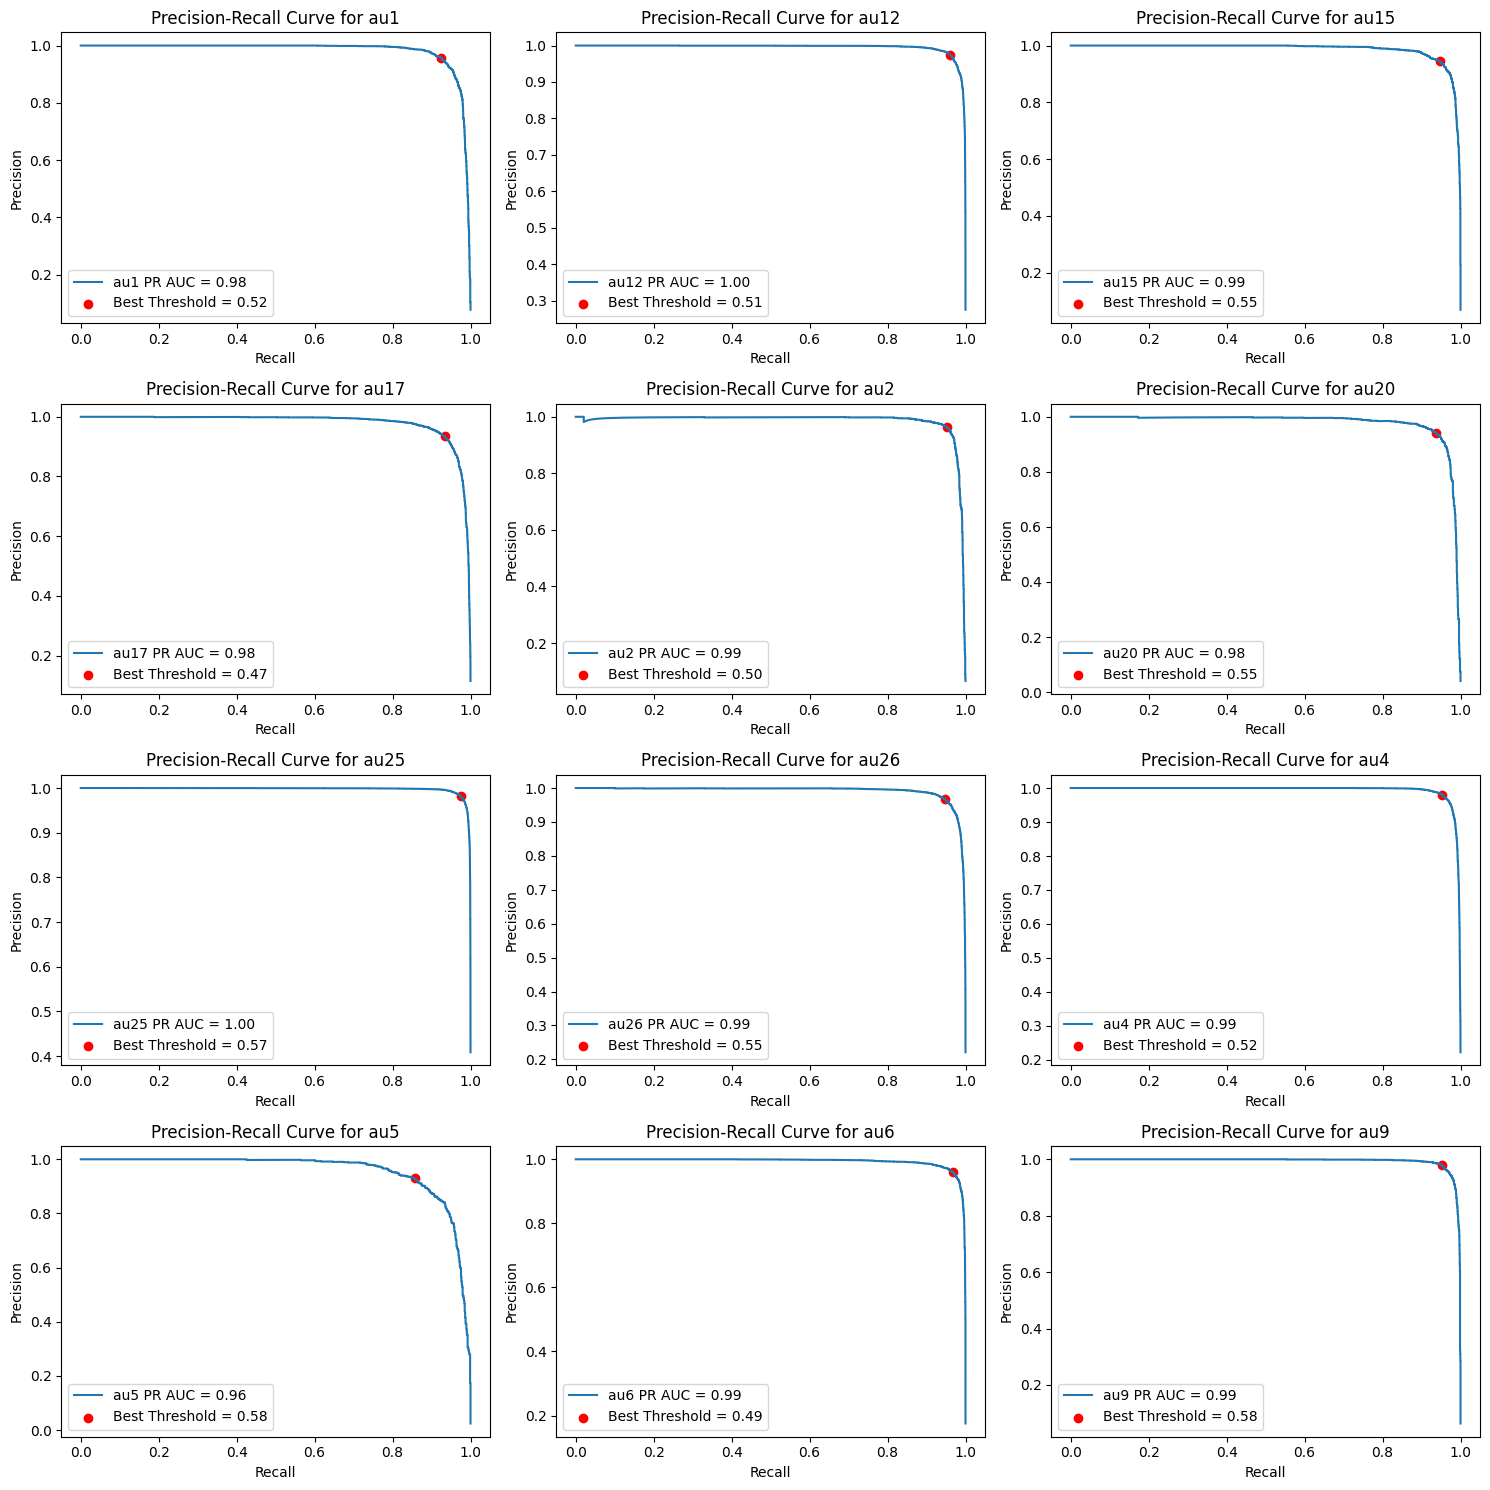

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Assuming y_test contains the true binary labels and pred contains the predicted probabilities
# au contains the names of the action units or labels
au = col
t=[]
# Create a figure and a grid of subplots (4x3)
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easier indexing
test_labels=y_test
# Loop through each label
for i in range(12):
    # Compute precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(test_labels[:, i], pred[:, i])

    # Calculate the precision-recall AUC
    pr_auc = auc(recall, precision)

    # Compute F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the threshold that maximizes the F1 score
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    t.append(best_threshold)
    best_f1 = f1_scores[best_threshold_index]

    # Plot the precision-recall curve
    ax = axes[i]
    ax.plot(recall, precision, label=f'{au[i]} PR AUC = {pr_auc:.2f}')
    ax.scatter(recall[best_threshold_index], precision[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve for {au[i]}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [16]:
y_pred = (pred >= t).astype(int)


Accuracy of each action unit 
au1   :  0.9910873440285205
au12   :  0.9824038706391648
au15   :  0.9924879042526101
au17   :  0.9849503437738731
au2   :  0.9944996180290298
au20   :  0.995161701044054
au25   :  0.9825566590272473
au26   :  0.9812834224598931
au4   :  0.9855360325948561
au5   :  0.9950343773873186
au6   :  0.9873185637891521
au9   :  0.9957983193277311


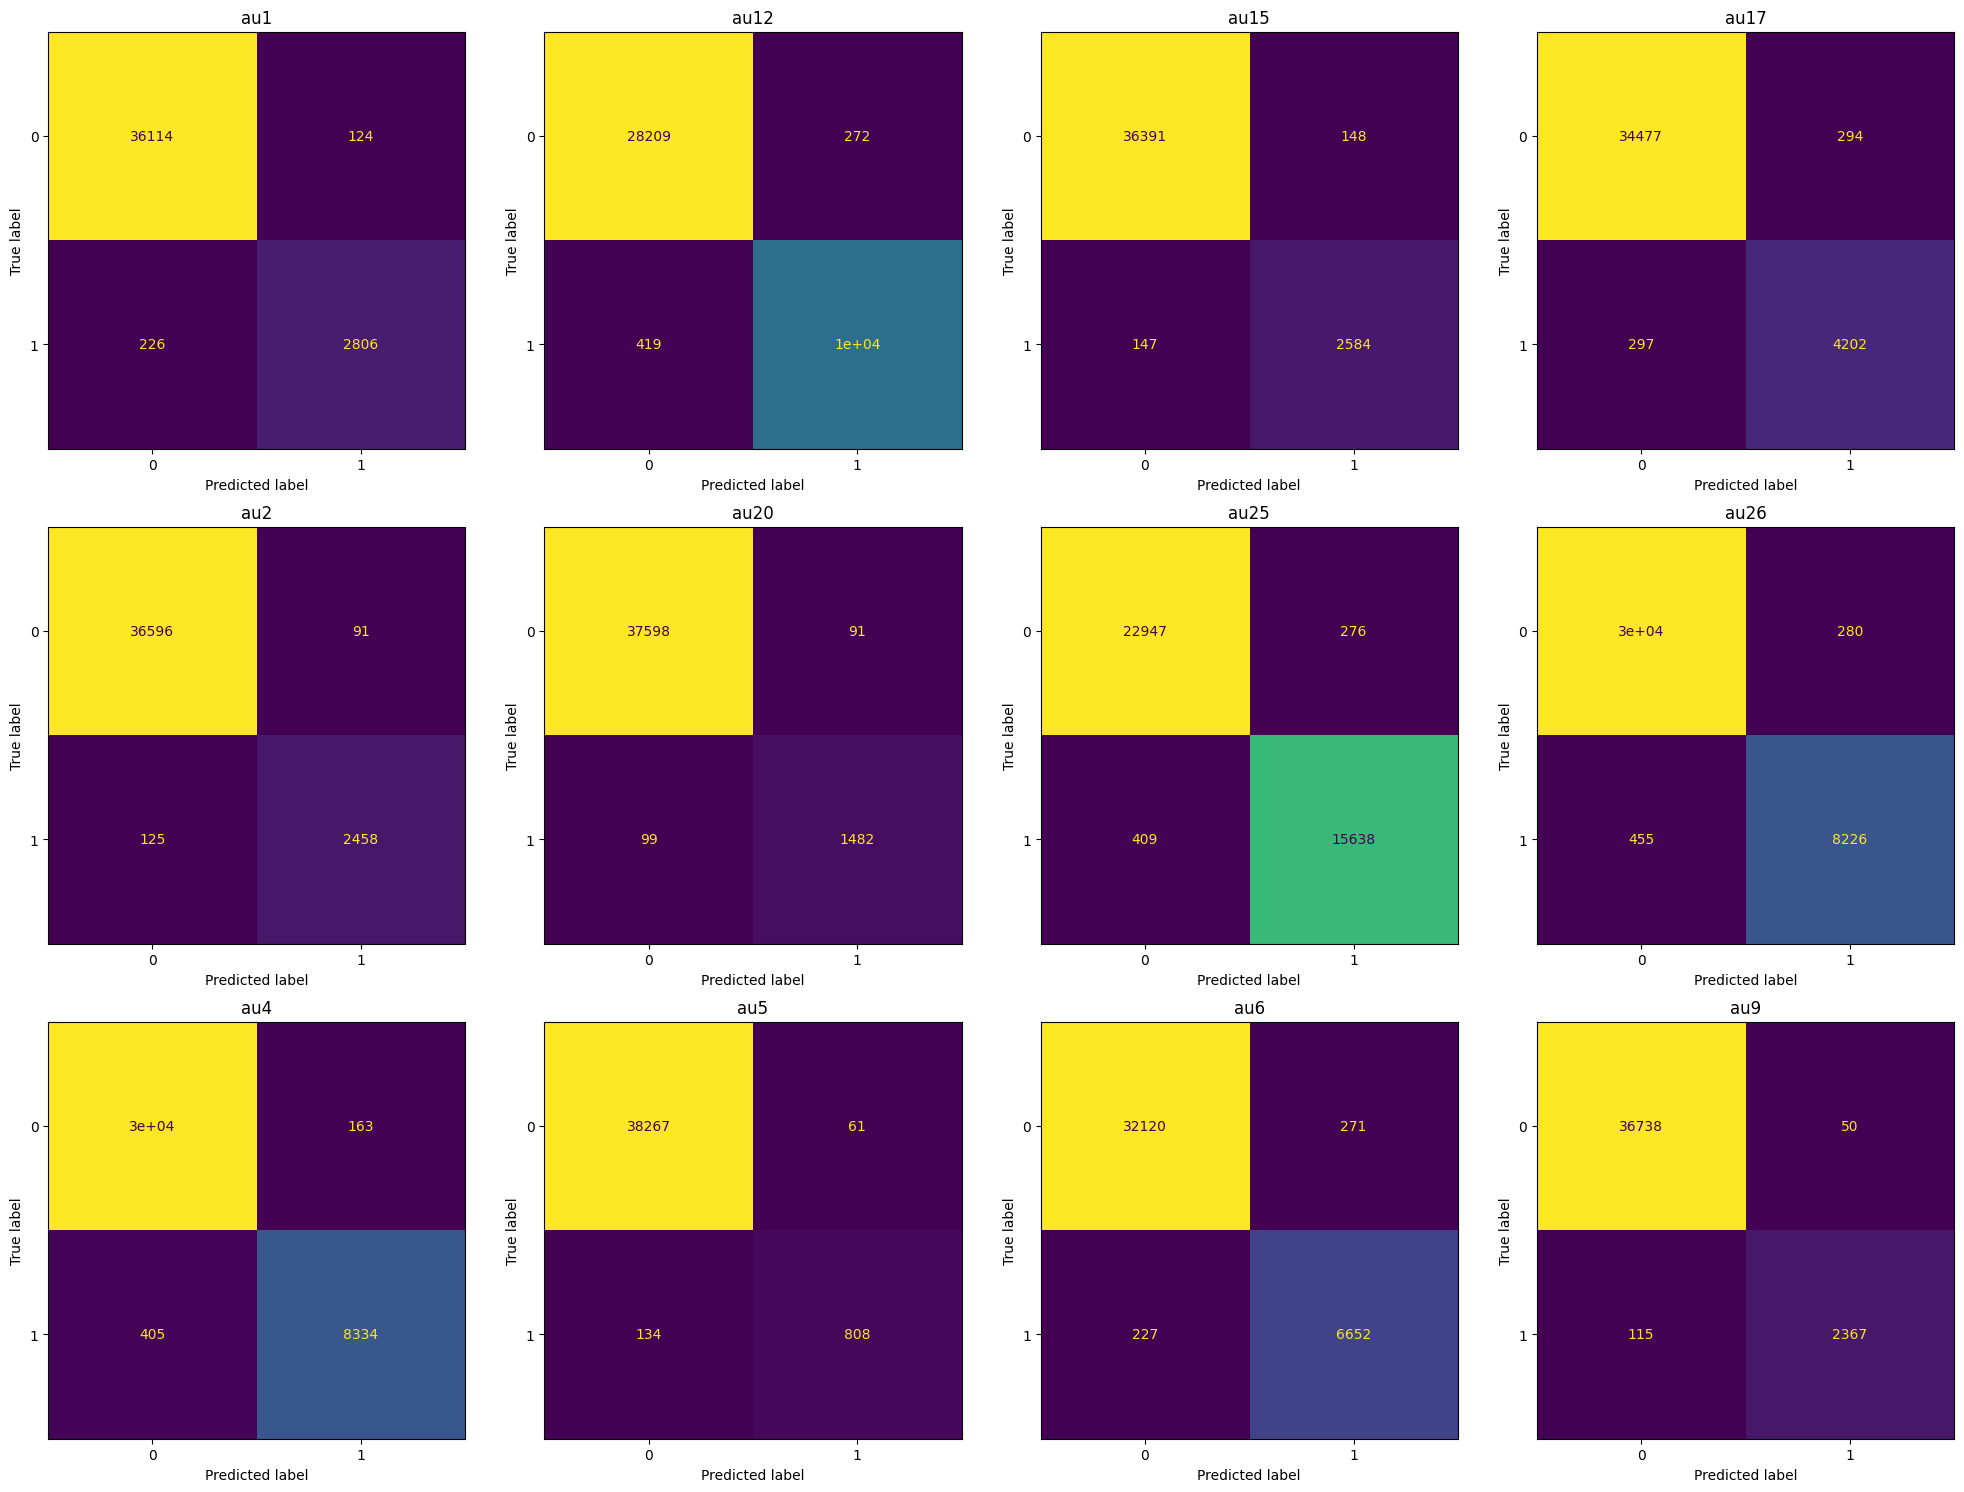

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()
p=y_pred
print("Accuracy of each action unit ")

for i in range(12):
    print(f'{au[i] }   : ', accuracy_score(test_labels[:, i], p[:, i]))
for i in range(12):
    cm = confusion_matrix(test_labels[:, i], p[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(au[i])

# Adjust layout
plt.tight_layout()
plt.show()

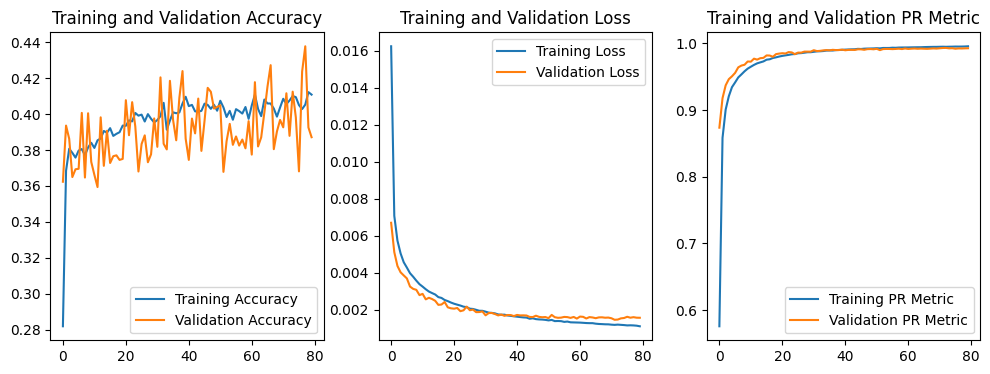

In [18]:
import matplotlib.pyplot as plt

# Extracting data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
pr_metric = history.history['auc']
val_pr_metric = history.history['val_auc']

epochs_range = range(len(acc))

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Plotting PR metric
plt.subplot(1, 3, 3)
plt.plot(epochs_range, pr_metric, label='Training PR Metric')
plt.plot(epochs_range, val_pr_metric, label='Validation PR Metric')
plt.legend(loc='lower right')
plt.title('Training and Validation PR Metric')

plt.show()

In [19]:
model.save('vit.keras')